# Clustering

In [27]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from scipy import stats

# Clustering
from sklearn import cluster, preprocessing
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Visualization
from sklearn import manifold

Defining a few functions which will help us with clustering

In [3]:
# getting most frequent product label for each customer
def get_first_element(s):
    """In the case s is a pd.Series containing tuples of arrays, returns the first element of the first
    array."""
    
    return s.map(lambda x: x[0][0])

# RFM

In [71]:
rfm = pd.read_csv("./data/rfm.csv")

# RFM and Products

Loading the datasets we will use in this section

In [66]:
df_clusterProducts = pd.read_csv("./data/data_categories.csv")
products_items = pd.read_csv("./data/products_items.csv")

## Products clustering

Starting by clustering products into broader categories: finding out the optimal number of clusters

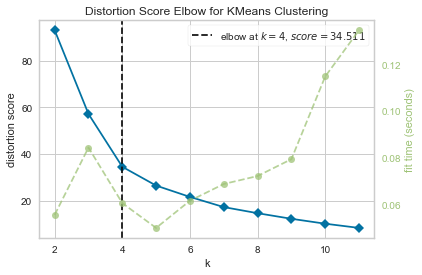

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [67]:
# comment the variables that should be taken into account for the clustering
df_clusterProducts = df_clusterProducts.drop(columns=[#"product_volume",
                    #"product_weight_g",
                    #"price",
                    "freight_to_total_price"
                   ]).dropna().set_index(["product_category_name_english"])

scaler = preprocessing.StandardScaler().fit(df_clusterProducts)
df_clusterProducts_norm = scaler.transform(df_clusterProducts)
df_clusterProducts_norm = pd.DataFrame(data=df_clusterProducts_norm, columns=df_clusterProducts.columns)


# Instantiate the clustering model and visualizer
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(df_clusterProducts_norm)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

Assessing the shape of the clusters

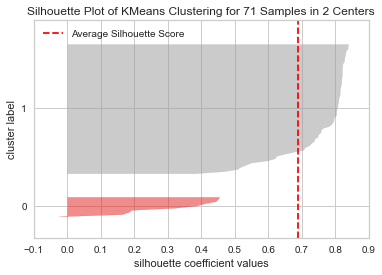

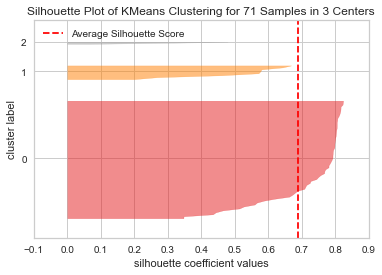

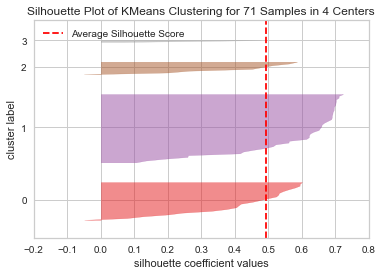

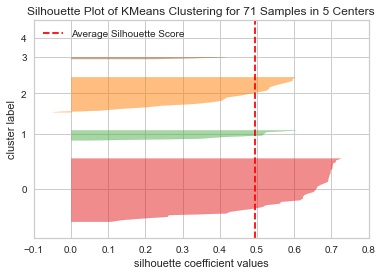

In [63]:
for n_clust in range(2, 6):
# Instantiate the clustering model and visualizer 
    model = cluster.KMeans(n_clusters=n_clust)
    visualizer = SilhouetteVisualizer(model)

    visualizer.fit(df_clusterProducts_norm)    # Fit the data to the visualizer
    visualizer.poof()    # Draw/show/poof the data

Visualization of the results of clustering for the optimal number of clusters found previously, and assessment of the stability of the clusters

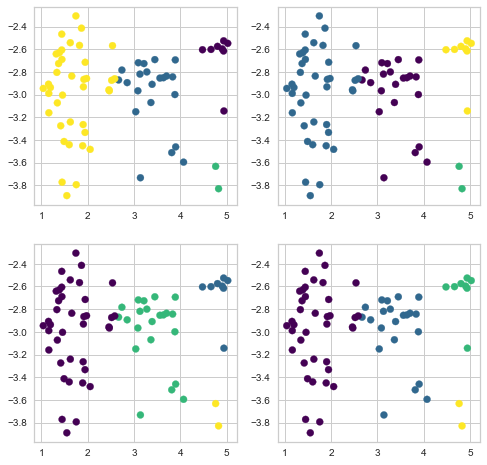

In [68]:
clustprod_std = df_clusterProducts_norm.copy()
clustprod = df_clusterProducts.copy()

fig = plt.figure(figsize=(8, 8))

for i in range(4):
    
    clusters = cluster.KMeans(n_clusters=4).fit(clustprod_std)
    
    # adding the labels obtained from clustering
    clustprod["product_label"] = clusters.labels_
    clustprod_std["product_label"] = clusters.labels_
    
    # The coordinates (standardized) for each product, and the associated category
    categories_norm = pd.concat((clustprod_std, 
                             clustprod.reset_index()["product_category_name_english"]
                            ),
                            axis=1
                           )

    # Visualization
    X = categories_norm.set_index("product_category_name_english")[["product_weight_g","price","product_volume"]]
    tsne = manifold.TSNE(n_components=2, perplexity=50, n_iter=3000, init='pca')
    X_tsne = tsne.fit_transform(X)
    
    ax = fig.add_subplot(2,2,i+1)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=categories_norm["product_label"], cmap="viridis")
plt.show()

<AxesSubplot:xlabel='product_volume', ylabel='price'>

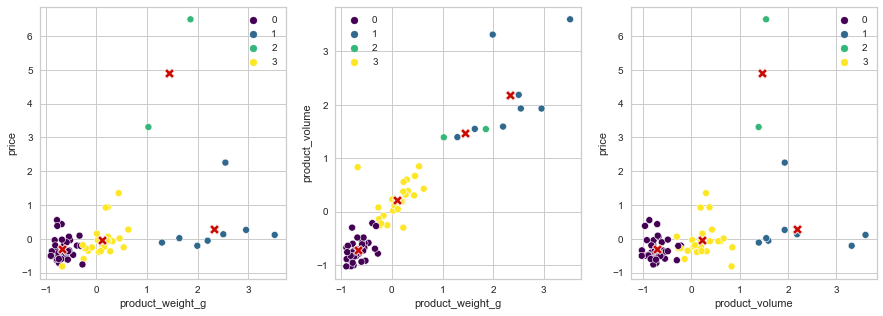

In [69]:
clusters = cluster.KMeans(n_clusters=4).fit(df_clusterProducts_norm)
centroids = pd.DataFrame(clusters.cluster_centers_, 
                         columns=["centroid_weight_g", "centroid_price", "centroid_volume"])

# adding the labels obtained from clustering
df_clusterProducts["product_label"] = clusters.labels_
df_clusterProducts_norm["product_label"] = clusters.labels_
    
# The coordinates (standardized) for each product, and the associated category
categories_norm = pd.concat((df_clusterProducts_norm, 
                             df_clusterProducts.reset_index()["product_category_name_english"]
                            ),
                            axis=1
                           )

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
sns.scatterplot(data=categories_norm,
                x="product_weight_g",
                y="price",
                hue="product_label",
                palette='viridis',
                ax=ax1
               )
sns.scatterplot(data=centroids,
                x="centroid_weight_g",
                y="centroid_price",
                s=100,
                color='r',
                marker='X',
                ax=ax1
               )

sns.scatterplot(data=categories_norm,
                x="product_weight_g",
                y="product_volume",
                hue="product_label",
                palette='viridis',
                ax=ax2
               )
sns.scatterplot(data=centroids,
                x="centroid_weight_g",
                y="centroid_volume",
                s=100,
                color='r',
                marker='X',
                ax=ax2
               )

sns.scatterplot(data=categories_norm,
                x="product_volume",
                y="price",
                hue="product_label",
                palette='viridis',
                ax=ax3
               )
sns.scatterplot(data=centroids,
                x="centroid_volume",
                y="centroid_price",
                s=100,
                color='r',
                marker='X',
                ax=ax3
               )

## RFM - products clustering

We merge the rfm data for each customer and the new product categories in order to perform a clustering of customers based on their rfm characteristics and the type of product they typically buy.

In [72]:
df_products = (pd.merge(products_items, df_clusterProducts["product_label"],
                        on="product_category_name_english",
                        right_index=True)
               .drop_duplicates()
              )

# We use rfm, the dataframe used to perform RFM segmentation as it is a good starting point.
# We merge rfm with customers_data in order to get the id for each transaction (customer_id) as well as
# the customer_city.
rfm_customers = (pd.merge(rfm, customers_data, on="customer_unique_id", left_index=True)
                 .drop_duplicates()
                )
rfm_customers.index = pd.Index(range(rfm_customers.shape[0]))

# merging with order_data in order to get the order_id associated with the customer_id
rfm_orders = pd.merge(rfm_customers, 
                      orders_data.drop(columns=["purchase_recency"]), 
                      on="customer_id",
                      left_index=True)

# merging with items_data in order to get the price of items within each order (order_id)
rfm_items = pd.merge(rfm_orders, items_data, on="order_id")

# merging with product_items in order to get the product categories.
rfm_product = (pd.merge(rfm_items[["customer_unique_id",
                                  "order_id",
                                  "purchase_recency",
                                  "frequency",
                                  "total_order_value"]], 
                       df_products, 
                       on="order_id", 
                       right_index=False)
               .drop_duplicates(subset=["customer_unique_id","order_id","product_id"])
              )

rfm_product.head()

NameError: name 'customers_data' is not defined

Let us now move on to clustering the customers based on RFM, and product_label

In [ ]:
cluster_products_customers = rfm_product[["customer_unique_id",
                                          "purchase_recency", 
                                          "frequency", 
                                          "total_order_value",
                                          "product_label"]].copy()

# getting the most frequent product type (product label) for each customer, in order to characterize each
# customer according to the most frequently bought product type.

# first, we get rid of potential duplicates
cluster_products_customers.drop_duplicates(inplace=True)

# Then, most frequent product type for each customer
product_labels = (cluster_products_customers
                    .groupby("customer_unique_id")["product_label"]
                    .agg(stats.mode)
                    .apply(lambda x: x[0][0])
                    .reset_index()
          )

# 
cluster_products_customers = (pd.merge(cluster_products_customers.drop(columns="product_label"),
                                       product_labels,
                                       on="customer_unique_id"
                                      )
                             )

# Again, cleaning up from potential duplicates arising from the merge operation
cluster_products_customers.drop_duplicates(inplace=True)

# Finally, we one-hot encode the product_label column
clust_df = pd.concat((cluster_products_customers.drop(columns=["customer_unique_id","product_label"]), 
                      pd.get_dummies(cluster_products_customers.product_label, prefix="label")), axis=1)

Finding out the optimal number of clusters
1. silhouette score

In [ ]:
scaler = preprocessing.StandardScaler().fit(clust_df)
clust_df_std = pd.DataFrame(data=scaler.transform(clust_df), columns=clust_df.columns)

silhouettes = []

for num_clusters in range(2, 10):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10).fit(clust_df_std)
    silh = metrics.silhouette_score(clust_df_std, cls.labels_, sample_size=1000)
    silhouettes.append(silh)

plt.plot(range(2, 10), silhouettes, marker='o')

2. Elbow method

In [ ]:
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(clust_df_std)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

Assessing the shape of the clusters

In [ ]:
for n_clust in range(4, 9):
# Instantiate the clustering model and visualizer 
    model = cluster.KMeans(n_clusters=n_clust)
    visualizer = SilhouetteVisualizer(model)

    visualizer.fit(clust_df_std.sample(10000))    # Fit the data to the visualizer
    visualizer.poof()

Assessing the stability of clusters

In [ ]:
clust_std = clust_df_std.copy()
clust = clust_df.copy()

fig = plt.figure(figsize=(8, 8))

for i in range(4):
    
    clusters = cluster.KMeans(n_clusters=4).fit(clust_std)
    
    # adding the labels obtained from clustering
    clust["customer_label"] = clusters.labels_
    clust_std["customer_label"] = clusters.labels_
    
    # The coordinates (standardized) for each customer, and the associated category
    #categories_norm = pd.concat((clust_std, 
    #                         clust["product_category_name_english"]
    #                        ),
    #                        axis=1
    #                       )

    # Visualization
    X = clust.copy()
    tsne = manifold.TSNE(n_components=2, perplexity=50, n_iter=3000, init='pca')
    X_tsne = tsne.fit_transform(X)
    
    ax = fig.add_subplot(2,2,i+1)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=categories_norm["customer_label"], cmap="viridis")
plt.show()

In [ ]:
clusters = cluster.KMeans(n_clusters=5, n_init=10).fit(clust_df_std)
centroids = clusters.cluster_centers_

scaler.inverse_transform(centroids)

### results for the clustering of customers based on their rfm and the main categories of products purchased

**Personae:**

|Persona#|N samples|purchase_recency|frequency|total_order_value|category 1|category 2|category 3|category 4|
|---|---|---|---|---|---|---|---|---|
|0|3467|305|1.03|249|0|1|0|0|
|1|43758|291|1|159|0|0|1|0|
|2|43490|281|1|151|1|0|0|0|
|3|250|266|1|1169|0.004|0|0|0.996|
|4|2878|268|2.1|311|0.61|0.003|0.39|0|

# RFM and Geolocation

## Geolocation clustering

We'll start by clustering the cities into broader categories based on their "average population", i.e. the average purchase value of the orders made by customers and their size. We need data from rfm analysis and customer location.

In [ ]:
# We can reuse the rfm_customers dataset
cluster_cities = (rfm_customers
     .groupby("customer_city", dropna=False)["total_order_value"]
     .agg([np.mean, np.std, np.size])
     .rename(columns={"mean":"tov_avg", 
                      "std":"tov_std"
                     })
    )

cluster_cities.head()

Finding out the optimal number of clusters
1. Silhouette score

In [ ]:
scaler = preprocessing.StandardScaler().fit(cluster_cities)
cluster_cities_std = scaler.transform(cluster_cities)
silhouettes = []

for num_clusters in range(2, 20):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10).fit(cluster_cities_std)
    silh = metrics.silhouette_score(cluster_cities_std, cls.labels_)
    silhouettes.append(silh)

plt.plot(range(2, 20), silhouettes, marker='o')

2. Elbow method

In [ ]:
# Instantiate the clustering model and visualizer
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(cluster_cities_std)    # Fit the data to the visualizer
visualizer.poof() 

Assessing the shape of clusters

In [ ]:
for n_clust in range(3, 9):
# Instantiate the clustering model and visualizer 
    model = cluster.KMeans(n_clusters=n_clust)
    visualizer = SilhouetteVisualizer(model)

    visualizer.fit(cluster_cities_std)    # Fit the data to the visualizer
    visualizer.poof()    # Draw/show/poof the data

Assessing the stabilility of the clusters

In [ ]:
clusters = cluster.KMeans(n_clusters=5).fit(cluster_cities_std)
labels = clusters.labels_
cluster_cities["city_type"] = labels
cluster_cities_std = pd.DataFrame(cluster_cities_std, columns=["tov_avg", "size"])
df_std["city_type"] = labels
centers = scaler.inverse_transform(clusters.cluster_centers_)


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
sns.scatterplot(data=X,
                x="tov_avg",
                y="size",
                hue="city_type",
                palette="viridis",
                alpha=1,
                linewidth=0,
                ax=ax1
               )

for ax in [ax1, ax2]:
    ax.scatter(centers[:, 0], centers[:, 1], s=50, c='red', marker="+")
    for i in range(5):
        ax.text(centers[i, 0], centers[i, 1], i, fontsize=16, color='red')

Getting representatives for each cluster

In [ ]:
# distance to centroids
X_dist = clusters.transform(X_std)

for ct in np.unique(labels):
    label_indices = np.where(labels==ct)[0]
    min_label_idx = label_indices[np.argmin(X_dist[labels==ct, ct])]
    print("Best representative of type {}: {}".format(ct, X.reset_index().iloc[min_label_idx]["customer_city"]))